## Preparation

In [1]:
import fastbook
fastbook.setup_book()

from fastai.vision.all import *
from fastai.vision.widgets import *
from fastbook import *

import seaborn as sns

sns.set()

path = untar_data(URLs.PETS)
path_models = Path()
fname = (path/"images").ls()[0]

pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=100, min_scale=0.75))
dls = pets.dataloaders(path/"images")


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


## Train model

In [2]:
learn_1 = vision_learner(dls, resnet34, metrics=error_rate)
learn_1.fine_tune(1)


epoch,train_loss,valid_loss,error_rate,time
0,2.756790,1.175060,0.331529,04:54


epoch,train_loss,valid_loss,error_rate,time
0,1.205040,0.766846,0.242896,04:51


## Let's see how the Cross-Entropy works

#### This returns the dependent and independent variables, as a mini-batch

In [3]:
x, y = dls.one_batch()


#### Let’s see what is contained in our dependent variable

In [4]:
len(y)


64

In [5]:
preds, _ = learn_1.get_preds(dl=[(x, y)])


In [6]:
preds[0]


TensorBase([9.3429e-06, 1.8201e-06, 7.4959e-01, 3.1740e-04, 1.4909e-05, 8.5300e-06, 3.9014e-04, 1.2584e-03, 2.0488e-01, 3.0971e-06, 4.2754e-02, 6.6663e-06, 2.3066e-06, 5.1445e-07, 1.0946e-05, 6.0706e-06,
        3.3275e-06, 2.8069e-06, 1.3997e-06, 9.7118e-07, 6.6369e-07, 6.4767e-05, 7.3358e-05, 9.6720e-05, 2.5781e-05, 6.8409e-05, 1.0090e-06, 1.2489e-05, 1.8993e-04, 7.1171e-05, 8.0776e-05, 2.1825e-05,
        5.4851e-06, 9.4544e-06, 4.3919e-07, 8.7653e-06, 7.3326e-06])

### Softmax

#### Sum should be equal 1

In [7]:
len(preds[0]), preds[0].sum()


(37, TensorBase(1.0000))

#### Sigmoid

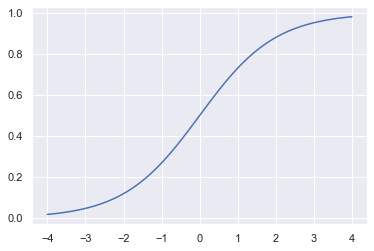

In [8]:
plot_function(torch.sigmoid, min=-4, max=4)


In [9]:
acts = torch.randn((6, 2))*2
acts


tensor([[ 0.1467, -1.6759],
        [-2.7469,  1.2929],
        [-3.3264, -0.6674],
        [-1.2777,  1.2582],
        [ 1.1777,  2.5570],
        [-1.6045, -3.3076]])

In [10]:
acts.sigmoid()


tensor([[0.5366, 0.1576],
        [0.0603, 0.7846],
        [0.0347, 0.3391],
        [0.2179, 0.7787],
        [0.7645, 0.9280],
        [0.1674, 0.0353]])

In [11]:
(acts[:, 0]-acts[:, 1]).sigmoid()


tensor([0.8609, 0.0173, 0.0654, 0.0734, 0.2011, 0.8459])

```python
def softmax(x): return exp(x) / exp(x).sum(dim=1, keepdim=True)
```

In [12]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts


tensor([[0.8609, 0.1391],
        [0.0173, 0.9827],
        [0.0654, 0.9346],
        [0.0734, 0.9266],
        [0.2011, 0.7989],
        [0.8459, 0.1541]])

### Log Likelihood

In [13]:
targ = tensor([0, 1, 0, 1, 1, 0])


In [14]:
sm_acts


tensor([[0.8609, 0.1391],
        [0.0173, 0.9827],
        [0.0654, 0.9346],
        [0.0734, 0.9266],
        [0.2011, 0.7989],
        [0.8459, 0.1541]])

In [15]:
idx = range(6)
sm_acts[idx, targ]


tensor([0.8609, 0.9827, 0.0654, 0.9266, 0.7989, 0.8459])

### NLL stands for negative log likelihood

the same as

```python
-sm_acts[idx, targ]
```

Despite its name, this PyTorch function does not take the log

In [16]:
F.nll_loss(sm_acts, targ, reduction='none')


tensor([-0.8609, -0.9827, -0.0654, -0.9266, -0.7989, -0.8459])

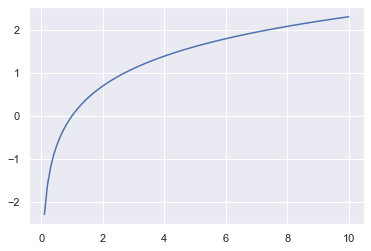

In [17]:
plot_function(torch.log, min=0, max=10)


PyTorch has a function called log_softmax that
combines log and softmax in a fast and accurate way. nll_loss is designed to be used after
log_softmax.

When we first take the softmax, and then the log likelihood of that, that combination
is called cross-entropy loss

 nn.CrossEntropyLoss which, in practice, does log_softmax and then
nll_loss

In [18]:
loss_func = nn.CrossEntropyLoss()


In [19]:
loss_func(acts, targ)


tensor(0.5603)

In [20]:
F.cross_entropy(acts, targ)


tensor(0.5603)

By default, PyTorch loss functions take the mean of the loss of all items. You can
use reduction='none' to disable that

In [21]:
nn.CrossEntropyLoss(reduction='none')(acts, targ)


tensor([0.1498, 0.0174, 2.7266, 0.0762, 0.2245, 0.1673])

It's too hard to read

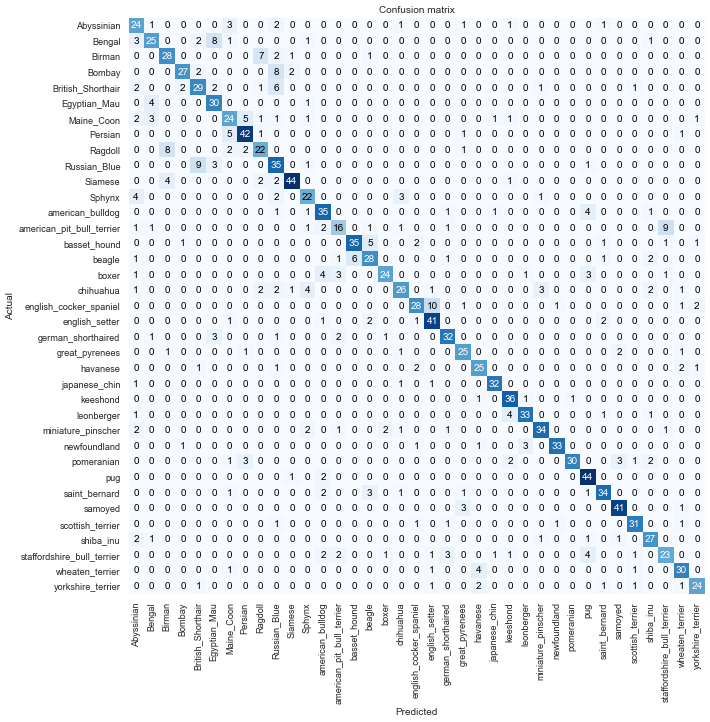

In [22]:
interp = ClassificationInterpretation.from_learner(learn_1)
interp.plot_confusion_matrix(figsize=(12, 12), dpi=60)


But we can use another method that shows us thew worst pred

In [23]:
interp.most_confused(min_val=5)


[('english_cocker_spaniel', 'english_setter', 10),
 ('Russian_Blue', 'British_Shorthair', 9),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 9),
 ('Bengal', 'Egyptian_Mau', 8),
 ('Bombay', 'Russian_Blue', 8),
 ('Ragdoll', 'Birman', 8),
 ('Birman', 'Ragdoll', 7),
 ('British_Shorthair', 'Russian_Blue', 6),
 ('beagle', 'basset_hound', 6),
 ('Maine_Coon', 'Persian', 5),
 ('Persian', 'Maine_Coon', 5),
 ('basset_hound', 'beagle', 5)]

## LR finder

In [24]:
learn_2 = cnn_learner(dls, resnet34, metrics=error_rate)
learn_2.fine_tune(1, base_lr=0.1)


d:\Projects\PythonProjects\DLS-Rush\venv\lib\site-packages\fastai\vision\learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


epoch,train_loss,valid_loss,error_rate,time
0,2.859871,3.112190,0.470230,04:41


epoch,train_loss,valid_loss,error_rate,time
0,3.190690,2.162799,0.649526,04:21


ValueError: not enough values to unpack (expected 2, got 1)

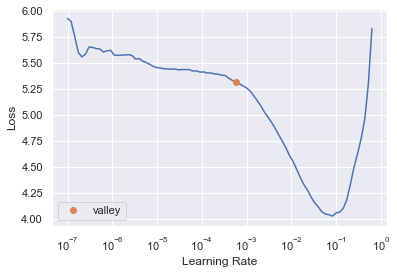

In [25]:
learn_3 = cnn_learner(dls, resnet34, metrics=error_rate)
lr_min, lr_steep = learn_3.lr_find()

In [26]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

NameError: name 'lr_min' is not defined

In [27]:
learn_4 = cnn_learner(dls, resnet34, metrics=error_rate)
learn_4.fine_tune(1, base_lr=0.1)


epoch,train_loss,valid_loss,error_rate,time


RuntimeError: CUDA out of memory. Tried to allocate 156.00 MiB (GPU 0; 2.00 GiB total capacity; 1.30 GiB already allocated; 0 bytes free; 1.67 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF